In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import cv2
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from numba import jit
from pathlib import Path
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
#import tables

In [2]:
#x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')
x = utils.get_data(directory= r'D:\runs\Run_21_18_56_1_2021-07-12')
#x = utils.get_data(test=True)

# Assign mother cells

In [3]:
df = x.positions
#x.get_colony_areas()

In [26]:

def plot_colony(obj,ts,colors=None,colony=None,ax=None,by=None,dims=x.metadata['Dimensions']):
    if not hasattr(obj,'colonies'):
        obj.get_mothers()
    df = obj.colonies
    ax = ax or plt.gca()
    timepoint = ts
  

    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    if by == 'Species' or by == 'species' or by == 'type':
        colors = {1 : (26,150,65) ,2 : (230,97,1)}
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[type_][0]),int(colors[type_][1]),int(colors[type_][2])),thickness = -1) for x,y, radius,type_ in zip(tp.x,tp.y,tp.radius,tp.type)]
    elif colony == None and by == None:
        tp = df[df.Timestep == timepoint]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(colors[cell][0]),int(colors[cell][1]),int(colors[cell][2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
    else:
        color = colors
        tp = df[(df.Timestep == timepoint) & (df.mother_cell==colony)]
        circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                    round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                    color = (int(color[0]),int(color[1]),int(color[2])),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]

    ax.imshow(bk)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

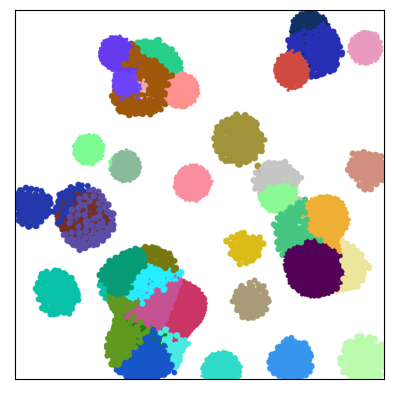

In [7]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
f,ax = plt.subplots()
plot.plot_colony(x,35000,colors,ax=ax)
plt.show()
f.tight_layout()
f.savefig('testcolony.png')

Assigning ancestry: 100%|██████████| 350/350 [00:21<00:00, 16.32it/s]


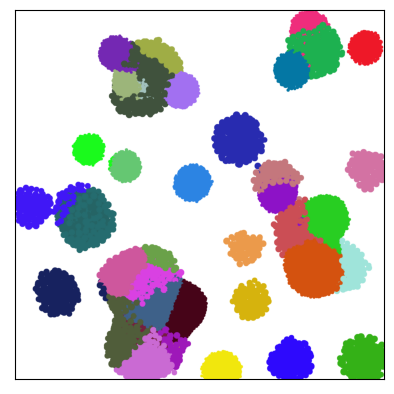

In [4]:
f,ax = plt.subplots()
plot.plot_colony(x,35000,ax=ax)
plt.show()

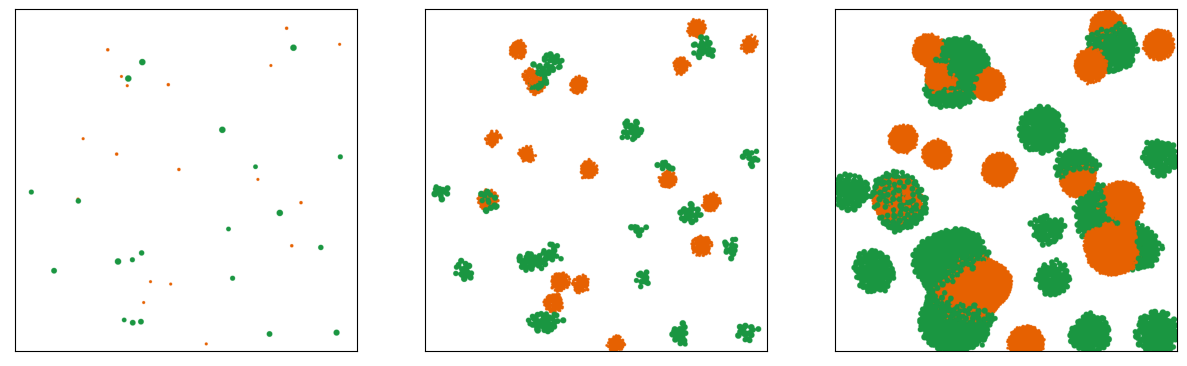

In [10]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
f, axes = plt.subplots(ncols=3,figsize=(15,5))

for ax, time in zip(axes,[100,20000,35000]):
    plot.plot_colony(x,time,by='Species',ax=ax)
plt.show()
f.tight_layout()
f.savefig('Colonies over time.png')

In [11]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}
#imgs= [plot_colony(df,time,colors) for time in tqdm(df.Timestep.unique())]

100%|██████████| 351/351 [00:49<00:00,  7.14it/s]


In [348]:
df

,Timestep,ID,type,radius,x,y,z,mother_cell,Colony Area
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,95,0
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,11,0
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,9,0
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,85,0
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,75,0
...,...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,52,0
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,52,0
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,52,0
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,52,0


In [ ]:
from joblib import Parallel, delayed
imgs = Parallel(n_jobs=6)(delayed(plot_colony)(df,time,colors) for time in tqdm(df.Timestep.unique()))
result = np.stack(imgs)
#im = delayed(np.stack)(imgs)



























































100%|██████████| 351/351 [00:14<00:00, 24.97it/s]


In [347]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}

In [361]:
df['Colony Area'] = 0
def count_colony_area(df,timestep,dims=dims):

    tp = df[df.Timestep == timestep]
    colonies = sorted(tp[tp.mother_cell != -1].mother_cell.unique())
    colors = {x :[x]*3 for x in colonies}
    img_size = 2000
    bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
    circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),
                round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),
                color = (cell,0,0),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
    cols, counts = np.unique(bk[:,:,0],return_counts=1)
    for colony,area in zip(cols[:-1],counts[:-1]):
        idx = df[(df.mother_cell==int(colony)) & (df.Timestep==timestep)].index
        df.loc[idx,'Colony Area'] = area

    

    return df




In [362]:
df2 = count_colony_area(df,35000)
df2

,Timestep,ID,type,radius,x,y,z,mother_cell,Colony Area
0,0,95,2,4.450000e-07,0.000025,0.000018,0.000002,95,0
1,0,11,1,9.600000e-07,0.000097,0.000027,0.000004,11,0
2,0,9,1,9.550000e-07,0.000193,0.000002,0.000005,9,0
3,0,85,2,4.845000e-07,0.000213,0.000014,0.000005,85,0
4,0,75,2,4.795000e-07,0.000125,0.000060,0.000005,75,0
...,...,...,...,...,...,...,...,...,...
1509472,35000,23090,2,4.200998e-07,0.000369,0.000451,0.000010,52,1011
1509473,35000,5557,2,4.937473e-07,0.000368,0.000452,0.000010,52,1011
1509474,35000,31029,2,4.517007e-07,0.000368,0.000452,0.000010,52,1011
1509475,35000,35847,2,4.201434e-07,0.000370,0.000452,0.000010,52,1011


In [360]:
for colony,area in zip(cols[:-1],counts[:-1]):
    df[(df.mother_cell==int(colony))]

In [353]:
df.mother_cell

0          95
1          11
2           9
3          85
4          75
           ..
1509472    52
1509473    52
1509474    52
1509475    52
1509476    52
Name: mother_cell, Length: 1509477, dtype: int64

In [341]:
colonies

array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 71, 72, 73, 74, 77, 78, 79,
       80, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99],
      dtype=uint8)

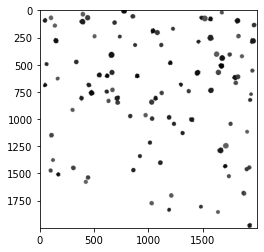

In [ ]:
bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)

circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),color = (cell,cell,cell),thickness = -1) for x,y, radius,cell in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]
plt.imshow(bk)
_, counts = np.unique(bk.reshape(-1,3), axis=0, return_counts=1)

In [ ]:
np.sum(bk[bk==[6,0,0]])

0

(array([12.,  7., 21., 12.,  9., 11.,  4.,  3.,  3.,  1.]),
 array([1.0000e+00, 4.8610e+02, 9.7120e+02, 1.4563e+03, 1.9414e+03,
        2.4265e+03, 2.9116e+03, 3.3967e+03, 3.8818e+03, 4.3669e+03,
        4.8520e+03]),
 <BarContainer object of 10 artists>)

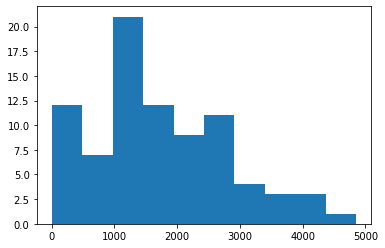

In [342]:
plt.hist(counts[:-1])

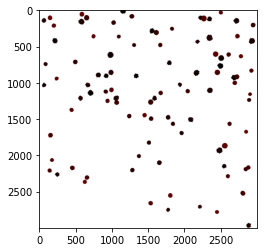

In [ ]:
img_size = 3000

bk = 255 * np.ones(shape=[img_size, img_size, 3], dtype=np.uint8)
temp = df[(df.Timestep==35000) & (df.mother_cell !=-1)]
circles = [cv2.circle(bk,center = (round(x/dims[0]*img_size),round(y/dims[1]*img_size)),radius = round(radius/dims[1]*img_size),color = (cell,0,0),thickness = -1) for x,y, radius,cell in zip(temp.x,temp.y,temp.radius,temp.mother_cell)]
plt.imshow(bk)
_, counts = np.unique(bk.reshape(-1,3), axis=0, return_counts=1)

In [ ]:
np.sum(bk[bk==[6,0,0]])

60

In [284]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure
#fig, ax = plt.subplots()
fig = Figure()
canvas = FigureCanvas(fig)
ax = fig.subplots()
#colors = 100 * np.random.rand(len(tp))

patches = [Circle((x,y), size,color=(c/255,0,0,1)) for x,y, size,c in zip(tp.x,tp.y,tp.radius,tp.mother_cell)]

colors = np.array([(c,0,0,1) for c in tp.mother_cell])

p = PatchCollection(patches)

#p.set_array(colors)
ax.add_collection(p)
ax.set_aspect('equal', 'box')

canvas.draw()
X = np.array(canvas.renderer.buffer_rgba())
colonies, counts = np.unique(X.reshape(-1,4), axis=0, return_counts=1)

#for idx in tp.index:
    #x, y,radius,cell = tp.loc[idx, ['x', 'y','radius','mother_cell']]
#for x1, y1, r in zip(x, y, radii):
    #circle = Circle((x, y), radius,color=(cell/255,cell/255,cell/255))
    #patches.append(circle)

#p = PatchCollection(circles, alpha=1)

#ax.add_collection(p)

In [287]:
colors[:,0].max()

99

In [267]:
np.ones([5,3]).reshape(-1,3)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

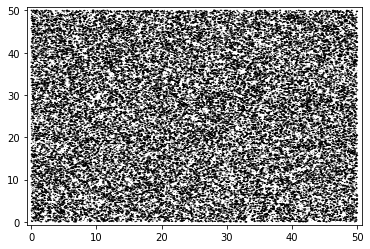

In [128]:
num = 46000
sizes = 0.2 * np.random.random(num)
xy = 50 * np.random.random((num, 2))

# Note that the patches won't be added to the axes, instead a collection will
patches = [Circle(center, size) for center, size in zip(xy, sizes)]

fig, ax = plt.subplots()

coll = PatchCollection(patches, facecolors='black')
ax.add_collection(coll)

ax.margins(0.01)
plt.show()

In [74]:
areas = count_colony_area(df,35000)

In [65]:
cols, counts = np.unique(areas.reshape(-1,3), axis=0, return_counts=1)



In [146]:
cols

array([[  1,   1,   1],
       [  2,   2,   2],
       [  4,   4,   4],
       [  5,   5,   5],
       [  7,   7,   7],
       [  8,   8,   8],
       [ 10,  10,  10],
       [ 11,  11,  11],
       [ 12,  12,  12],
       [ 13,  13,  13],
       [ 14,  14,  14],
       [ 15,  15,  15],
       [ 16,  16,  16],
       [ 17,  17,  17],
       [ 18,  18,  18],
       [ 19,  19,  19],
       [ 20,  20,  20],
       [ 21,  21,  21],
       [ 22,  22,  22],
       [ 23,  23,  23],
       [ 24,  24,  24],
       [ 25,  25,  25],
       [ 26,  26,  26],
       [ 27,  27,  27],
       [ 28,  28,  28],
       [ 29,  29,  29],
       [ 30,  30,  30],
       [ 31,  31,  31],
       [ 32,  32,  32],
       [ 33,  33,  33],
       [ 34,  34,  34],
       [ 35,  35,  35],
       [ 36,  36,  36],
       [ 37,  37,  37],
       [ 39,  39,  39],
       [ 40,  40,  40],
       [ 42,  42,  42],
       [ 44,  44,  44],
       [ 45,  45,  45],
       [ 46,  46,  46],
       [ 47,  47,  47],
       [ 48,  48

In [76]:

colony_areas = [count_colony_area(df,time) for time in tqdm(df.Timestep.unique())]

  2%|▏         | 7/351 [00:27<22:36,  3.94s/it]

KeyboardInterrupt: 

In [77]:
colony_areas = Parallel(n_jobs=6)(delayed(count_colony_area)(df,time) for time in tqdm(df.Timestep.unique()))

KeyboardInterrupt: 

In [ ]:
colony_areas

False

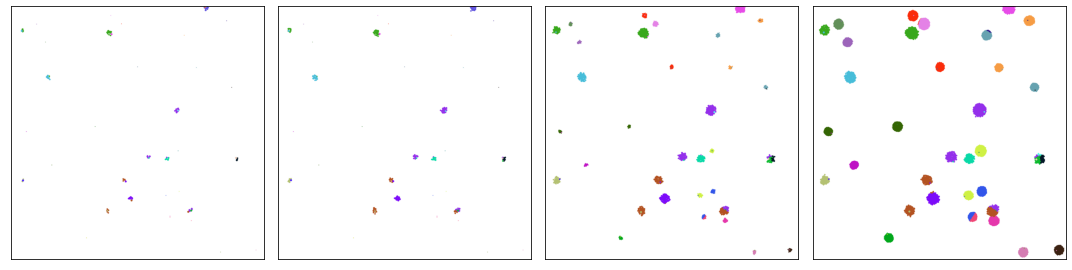

In [28]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}

f, axes = plt.subplots(ncols=4,figsize=(15,10))
for time,ax in zip([15000,20000,30000,35000],axes.ravel()):
    img = plot_colony(df,time,colors)
    ax.imshow(img[:1000,:1000,:])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

f.tight_layout()

In [ ]:
#def colony_area(df,h,w):
h = 2000
w = 2000
#df = x.colonies

colonies = df.mother_cell.unique()
df['Colony Area'] = 0
for time in tqdm(sorted(df.Timestep.unique())):
    for colony in colonies:
        mask = np.zeros((h, w, 3), dtype="uint8")
        for cell in df[(df.mother_cell==colony) & (df.Timestep==time)].itertuples():
            
            xloc = round(cell[5]/x.metadata['Dimensions'][0]*w)
            yloc = round(cell[6]/x.metadata['Dimensions'][1]*h)
            radius = round(cell[4]/x.metadata['Dimensions'][0]*h)
                
            cv2.circle(mask,center = (xloc,yloc),radius = radius,color = (255,255,255),thickness = -1)
        idx = df[(df.mother_cell==colony) & (df.Timestep==time)].index
        area = np.count_nonzero(mask)
        df.loc[idx,'Colony Area'] = area

    #return mask
#colony_area(x.colonies,2000,2000)

100%|██████████| 351/351 [12:12<00:00,  2.09s/it]


KeyboardInterrupt: 

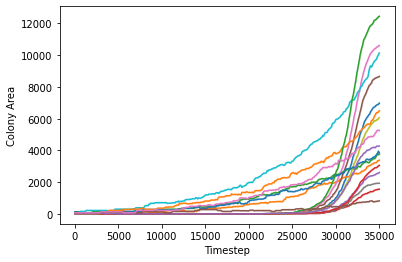

In [ ]:
for colony in colonies:
    sns.lineplot(x='Timestep',y='Colony Area',data= df[(df.mother_cell==colony)])

In [ ]:
df[df.mother_cell==87]

,Timestep,ID,type,radius,x,y,z,mother_cell,Colony Area
29,0,87,2,4.600000e-07,0.000165,0.000143,0.000007,87,39
128,100,87,2,4.567775e-07,0.000165,0.000143,0.000007,87,39
230,200,87,2,4.535770e-07,0.000165,0.000143,0.000007,87,39
332,300,87,2,4.503987e-07,0.000165,0.000143,0.000007,87,39
420,400,103,1,7.964282e-07,0.000163,0.000103,0.000007,87,126
...,...,...,...,...,...,...,...,...,...
1477836,35000,31412,2,4.708929e-07,0.000160,0.000144,0.000010,87,18732
1477837,35000,44351,2,4.326158e-07,0.000162,0.000144,0.000010,87,18732
1477843,35000,23520,2,4.034584e-07,0.000160,0.000145,0.000010,87,18732
1477844,35000,35066,2,4.487172e-07,0.000162,0.000145,0.000010,87,18732


In [ ]:
winners =df2[df2.Timestep==df2.Timestep.max()].sort_values(by='Colony Area')[['mother_cell','type','Colony Area']].drop_duplicates().reset_index(drop=True)
winners.mother_cell.unique()

array([21,  6, 98, 83, 64,  3, 18,  7, 75, 88, 49,  2, 86, 37, 41, 69, 39,
       84, 96, 36, 61, 66, 65, 14, 15, 60, 33, 57, 23, 97, 43, 56, 59, 81,
       27, 16, 26, 76, 62,  4, 58, 70, 25, 45, 29, 55, 10, 30, 12, 72, 52,
       48, 71,  1, 68, 24, 77, 85, 94, 91, 44,  8, 92, 32, 28, 53, 99, 67,
       50, 78, 22, 63, 34, 90, 42, 73, 20, 31, 79, 40, 13, 35, 47, 19, 95,
       82, 17, 51, 93, 89, 80, 38, 11,  9,  5, 74, 54, 46, 87],
      dtype=int64)

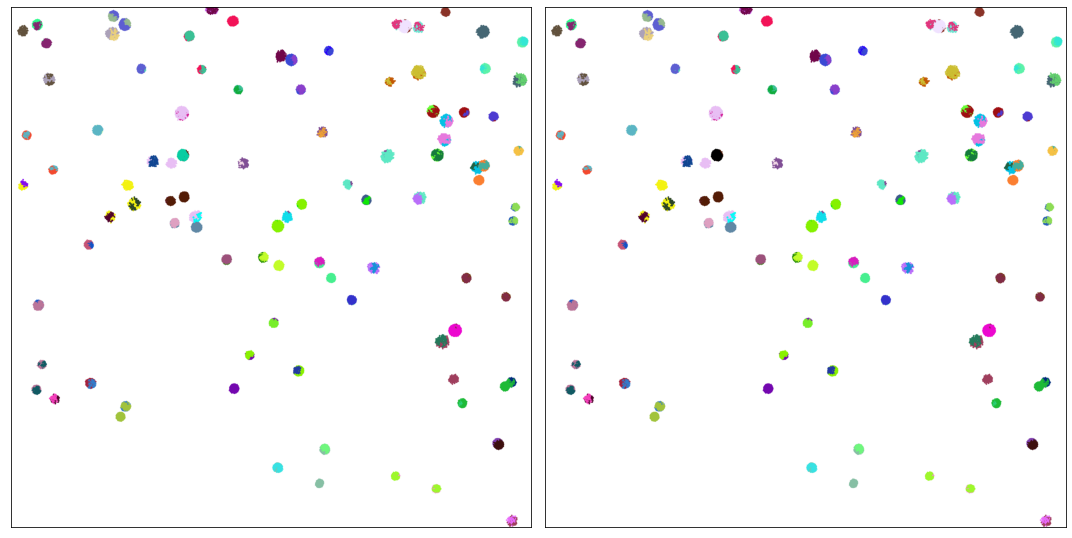

In [ ]:
IDs = sorted(df[df.mother_cell != -1].mother_cell.unique())
colors = {x : tuple(np.random.randint(0,256, 3).astype('int')) for x in IDs}

f, axes = plt.subplots(ncols=2,figsize=(15,10))

img = plot_colony(df2,35000,colors)
axes[0].imshow(img)

img = plot_colony(df2,35000,colors=(0,0,0),colony = 87,img=img)
axes[1].imshow(img)
for ax in axes:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

f.tight_layout()

In [ ]:
from skimage.draw import disk

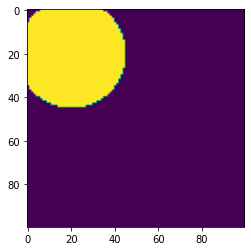

In [ ]:
shape = (100, 100)
img = np.zeros(shape, dtype=np.uint8)
rr, cc = disk((20, 20), 25, shape=shape)
img[rr, cc] = 1
plt.imshow(img)

In [15]:
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure
data =df[(df.Timestep==35000)]

areas = list()
for colony in data.mother_cell.unique():
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    temp = data[data.mother_cell ==colony]
    ax.scatter(x=temp.x,y=temp.y,s=np.sqrt(temp.radius))
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    areas.append([colony,np.count_nonzero(X)])
ax.set_aspect('equal', 'box')



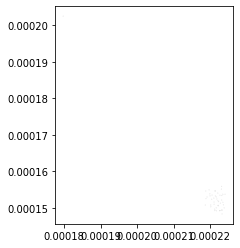

In [20]:
temp = data[data.mother_cell ==1]
plt.scatter(x=temp.x,y=temp.y,s=np.sqrt(temp.radius),c='k')
ax = plt.gca()
ax.set_aspect('equal', 'box')

In [14]:
def count_area(df):
    colonies = df.mother_cell.unique()
    df['Colony Area'] = 0
    for time in tqdm(sorted(df.Timestep.unique())):
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.subplots()
        for colony in colonies:

            temp = df[(df.mother_cell==colony) & (df.Timestep==time)]
            ax.scatter(x=temp.x,y=temp.y,s=np.sqrt(temp.radius))
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())
            idx = df[(df.mother_cell==colony) & (df.Timestep==time)].index
            area = np.count_nonzero(mask)
            df.loc[idx,'Colony Area'] = area
    return df
df_area = count_area(df)

  0%|          | 0/351 [00:00<?, ?it/s]


NameError: name 'Figure' is not defined

In [ ]:
ddf = pd.DataFrame(areas,columns=['Colony','Area'])
plt.scatter(ddf.Colony,ddf.Area)


NameError: name 'areas' is not defined